In [22]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
from transformers import DataCollatorForTokenClassification
from matplotlib import pyplot as plt 

In [23]:
wmout = load_dataset('alfarruggia/wmout')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [24]:
# https://huggingface.co/docs/transformers/en/tasks/token_classification
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [25]:
tokenized_mout = wmout.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

In [26]:

label_list = ["0", "B-Workout", "I-Workout", "I-Frequency", "B-Frequency", "I-Duration", "B-Number", "B-Duration"]
id2label = {}
label2id = {}

for i, v in enumerate(label_list):
    id2label[i] = v
    label2id[v] = i

In [27]:
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [28]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(label_list), id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=11,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=3
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_mout["train"],
    eval_dataset=tokenized_mout["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model('./model_output')

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.20979496836662292, 'eval_precision': 0.8898601398601399, 'eval_recall': 0.9187725631768953, 'eval_f1': 0.9040852575488455, 'eval_accuracy': 0.9572147651006712, 'eval_runtime': 0.198, 'eval_samples_per_second': 388.985, 'eval_steps_per_second': 25.259, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.056623704731464386, 'eval_precision': 0.9744990892531876, 'eval_recall': 0.9657039711191335, 'eval_f1': 0.970081595648232, 'eval_accuracy': 0.9890939597315436, 'eval_runtime': 0.1944, 'eval_samples_per_second': 396.026, 'eval_steps_per_second': 25.716, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.047795526683330536, 'eval_precision': 0.9744990892531876, 'eval_recall': 0.9657039711191335, 'eval_f1': 0.970081595648232, 'eval_accuracy': 0.9890939597315436, 'eval_runtime': 0.1603, 'eval_samples_per_second': 480.239, 'eval_steps_per_second': 31.184, 'epoch': 3.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.04708970710635185, 'eval_precision': 0.9800362976406534, 'eval_recall': 0.9747292418772563, 'eval_f1': 0.9773755656108597, 'eval_accuracy': 0.9916107382550335, 'eval_runtime': 0.1754, 'eval_samples_per_second': 439.04, 'eval_steps_per_second': 28.509, 'epoch': 4.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.04576309770345688, 'eval_precision': 0.9801801801801802, 'eval_recall': 0.9819494584837545, 'eval_f1': 0.9810640216411181, 'eval_accuracy': 0.9924496644295302, 'eval_runtime': 0.1584, 'eval_samples_per_second': 486.089, 'eval_steps_per_second': 31.564, 'epoch': 5.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.045557159930467606, 'eval_precision': 0.9855334538878843, 'eval_recall': 0.983754512635379, 'eval_f1': 0.984643179765131, 'eval_accuracy': 0.9932885906040269, 'eval_runtime': 0.201, 'eval_samples_per_second': 383.163, 'eval_steps_per_second': 24.881, 'epoch': 6.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.04233548417687416, 'eval_precision': 0.9801801801801802, 'eval_recall': 0.9819494584837545, 'eval_f1': 0.9810640216411181, 'eval_accuracy': 0.9924496644295302, 'eval_runtime': 0.149, 'eval_samples_per_second': 516.921, 'eval_steps_per_second': 33.566, 'epoch': 7.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.043782345950603485, 'eval_precision': 0.9855334538878843, 'eval_recall': 0.983754512635379, 'eval_f1': 0.984643179765131, 'eval_accuracy': 0.9932885906040269, 'eval_runtime': 0.1539, 'eval_samples_per_second': 500.279, 'eval_steps_per_second': 32.486, 'epoch': 8.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.04080745577812195, 'eval_precision': 0.9837837837837838, 'eval_recall': 0.9855595667870036, 'eval_f1': 0.9846708746618575, 'eval_accuracy': 0.9932885906040269, 'eval_runtime': 0.1914, 'eval_samples_per_second': 402.359, 'eval_steps_per_second': 26.127, 'epoch': 9.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.04214434325695038, 'eval_precision': 0.9873873873873874, 'eval_recall': 0.9891696750902527, 'eval_f1': 0.9882777276825969, 'eval_accuracy': 0.9941275167785235, 'eval_runtime': 0.1901, 'eval_samples_per_second': 405.025, 'eval_steps_per_second': 26.3, 'epoch': 10.0}


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/alfonsofarruggia/miniforge3/envs/nlp_api/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.04190324246883392, 'eval_precision': 0.9873873873873874, 'eval_recall': 0.9891696750902527, 'eval_f1': 0.9882777276825969, 'eval_accuracy': 0.9941275167785235, 'eval_runtime': 0.1473, 'eval_samples_per_second': 522.76, 'eval_steps_per_second': 33.945, 'epoch': 11.0}
{'train_runtime': 75.0467, 'train_samples_per_second': 90.877, 'train_steps_per_second': 5.716, 'train_loss': 0.10783927757423241, 'epoch': 11.0}


Text(0.5, 1.0, 'F1')

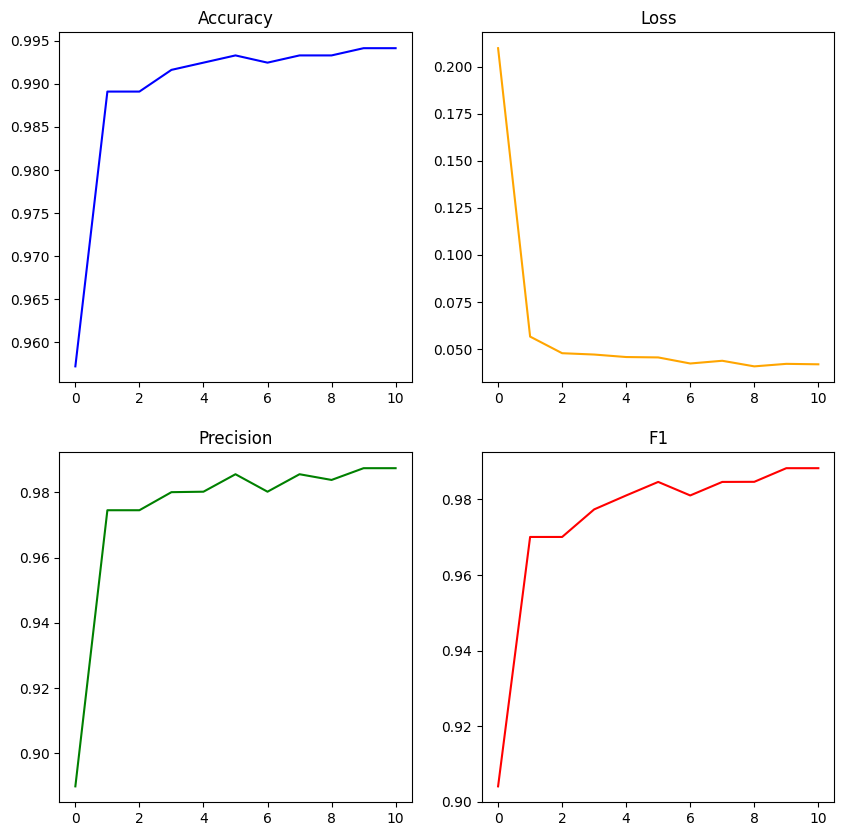

In [29]:
eval_loss = [ x.get('eval_loss') for x in  trainer.state.log_history]
eval_accuracy = [ x.get('eval_accuracy') for x in  trainer.state.log_history]
eval_precision = [ x.get('eval_precision') for x in  trainer.state.log_history]
eval_f1 = [ x.get('eval_f1') for x in  trainer.state.log_history]

figs, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].plot(range(0, len(eval_accuracy)),eval_accuracy, color='blue') 
ax[0, 0].set_title('Accuracy')

ax[0, 1].plot(range(0, len(eval_loss)),eval_loss, color='orange') 
ax[0, 1].set_title('Loss')

ax[1, 0].plot(range(0, len(eval_precision)),eval_precision, color='green') 
ax[1, 0].set_title('Precision')

ax[1, 1].plot(range(0, len(eval_f1)),eval_f1, color='red') 
ax[1, 1].set_title('F1')
